In [2]:
!pip install langchain_google_genai
!pip install langchain_core
!pip install langgraph
# !pip install langchain_openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.8 MB/s eta 0:00:00


In [3]:
# if using colab
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
# OPEN_AI_KEY = userdata.get('OPEN_AI_KEY')


In [ ]:
# if using notebook

!pip install python-dotenv
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not found. Make sure it's set in .env file.")

print("API Key Loaded Successfully")  # Check if it loads

API Key Loaded Successfully


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_openai import ChatOpenAI

llm = ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    api_key=GEMINI_API_KEY
)

# llm = ChatOpenAI(
#     model="gpt-4o",
#     api_key=OPEN_AI_KEY
#     )



In [27]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import Dict, Optional

class FrontendState(MessagesState):
  # """
  # State for the front-end agent.
  # We store:
  # - message: text from the user
  # - final_response: the front-end's consolidated reply
  # - subgraph output if we call the greeting subagent or the user preference agent

  # """
  is_greeting_route: bool = False
  greeting_response: Optional[str] = None
  name:str = None
  password:str = None

sys_msg = SystemMessage(content="""
You are a classification agent.
    A user message can be one of the following intents:
      1) Greeting (e.g., "hello", "hi")
      2) Store Intent (e.g., "My name is John", "My password is 1234" (if user gives passwords otherwise no need to respond), "John here")
      3) Retrieve Intent (e.g., "What is my name?", "What is my password?")

    You must respond with EXACTLY ONE of these lines:
      - "It is a greeting."
      - "store intent, name [name], password [password]"
      - "retrieve intent."
    Do note that the user may only provide the name. if it is then dont need to mention about password.
""")

def frontend_agent(state: FrontendState):
  response = llm.invoke([sys_msg] + state['messages'])
  state['messages'].append(response)

  if any(isinstance(m, AIMessage) and m.content == "It is a greeting." for m in state['messages']):
    state['is_greeting_route'] = True
    return state
  else:
    state['is_greeting_route'] = False
    return state



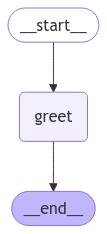

In [26]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


def greet(state: FrontendState):

  # Define a system message guiding the LLM
  system_prompt = SystemMessage(content="""
  You are a friendly assistant responsible for handling user greetings.
- If the user says "hello", "hi", "hey", or any greeting, respond in a **warm and engaging way**.
- Example Responses:
  - "Hello there! How can I help you today?"
  - "Hey! Great to see you. What’s on your mind?"
  - "Hi! How can I assist you today?"
  """)

  # Call LLM to generate a response
  ai_response = llm.invoke([system_prompt] + state['messages'])

  # Append the generated AI response
  state['messages'].append(ai_response)

  return {"messages": state['messages']}

sub_graph_builder = StateGraph(FrontendState)
sub_graph_builder.add_node("greet", greet)
sub_graph_builder.add_edge(START, "greet")
sub_graph_builder.add_edge("greet", END)

greeting_subgraph = sub_graph_builder.compile()

display(Image(greeting_subgraph.get_graph(xray=True).draw_mermaid_png()))


In [23]:
def routing_function(state: FrontendState):
  if state['is_greeting_route']== False:
    return "user_preference_graph_agent"
  return "greeting_subgraph"

In [24]:
system_message = SystemMessage(content="""
    You are a user preference agent responsible for storing and retrieving the user's credentials.
The frontend agent will provide one of two possible classifications:

1️⃣ **Store Intent** (e.g., "store intent, name John, password 1234"):
   - Extract the [name] and [password] from the message.
   - Store them in the conversation state (state['name'], state['password']).
   - Respond with a short confirmation, e.g.:
       "Got it! I've stored your name as John and password as 1234."
    Do note that the user may only provide the name. if it is then dont need to mention about password.

2️⃣ **Retrieve Intent** (e.g., "It is a retrieve intent."):
   - Check if state['name'] and state['password'] exist.
   - If they do, respond with something like:
       "Your name is John, and your password is 1234."
   - If any credential does not exist, respond accordingly, e.g.:
       "I don't have your name or password saved yet."
       (Adjust this if only one of them is missing.)

Be concise and clear in your final response.
""")

def user_preference_agent(state: FrontendState):
  if state['is_greeting_route'] == False:
    response = llm.invoke([system_message] + state['messages'])
    state['messages'].append(response)

    # parts = response.content.split()

    parts = state['messages'][-2].content.split(", ")
    # Extract the name and password securely
    if len(parts) >= 2:
        extracted_name = parts[1].split("name ", 1)[1]  # First word = name
        extracted_password = parts[2].split("password ", 1)[1]  # Second word = password
    else:
        extracted_name = "Unknown"
        extracted_password = "Unknown"

    # Store them in the state (but keep the password private)
    state['name'] = extracted_name
    state['password'] = extracted_password

    # 5) Return the updated state (including the LLM's natural language response)
    return state

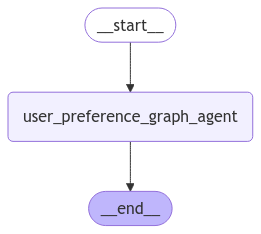

In [28]:
preference_graph_builder = StateGraph(FrontendState)
preference_graph_builder.add_node("user_preference_graph_agent", user_preference_agent)

preference_graph_builder.add_edge(START, "user_preference_graph_agent")
preference_graph_builder.add_edge("user_preference_graph_agent", END)

user_preference_graph_agent = preference_graph_builder.compile()

display(Image(user_preference_graph_agent.get_graph(xray=True).draw_mermaid_png()))

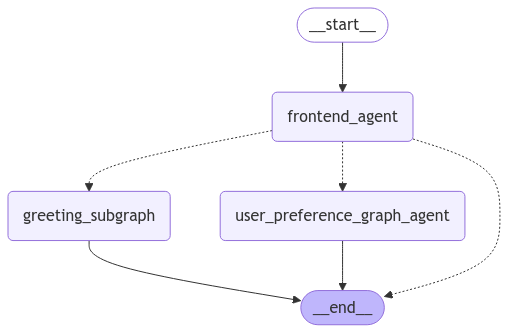

In [31]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


builder = StateGraph(FrontendState)
builder.add_node("frontend_agent", frontend_agent)
builder.add_node("greeting_subgraph", greeting_subgraph)
builder.add_node("user_preference_graph_agent", user_preference_graph_agent)


builder.add_edge(START, "frontend_agent")
builder.add_conditional_edges("frontend_agent", routing_function)
builder.add_edge("greeting_subgraph", END)
builder.add_edge("user_preference_graph_agent", END)


graph = builder.compile()


memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [32]:
messages = [HumanMessage(content="my name is amad and my password is khayabaneameen777")]
thread_config = {"configurable": {"thread_id": "1"}}

messages1 = graph.invoke({"messages": messages}, thread_config)

for m in messages1["messages"]:
  m.pretty_print()
# print(messages1['password'])

================================ Human Message =================================

my name is amad and my password is khayabaneameen777
================================== Ai Message ==================================

store intent, name amad, password khayabaneameen777
================================== Ai Message ==================================

Got it! I've stored your name as amad and password as khayabaneameen777.
